## 使用rasterio库
rasterio是基于GDAL库二次封装的用于空间栅格数据处理的Python库。  
rasterio支持多种栅格数据格式，如GeoTIFF、ENVI和HDF5，为处理和分析栅格数据提供了强大的工具。

### 计算mndwi

In [4]:
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

In [5]:
path_img = "E://YNU//5//OpenSourceGIS//Act_6//OnClass//chenggong_utm48.tif"

In [6]:
rsimg = rio.open(path_img)
rsimg.crs
rsimg.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 2875,
 'height': 3379,
 'count': 6,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 48N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32648"]]'),
 'transform': Affine(10.421454790528236, 0.0, 268167.02525260474,
        0.0, -9.543567381150961, 2765453.1872716597)}

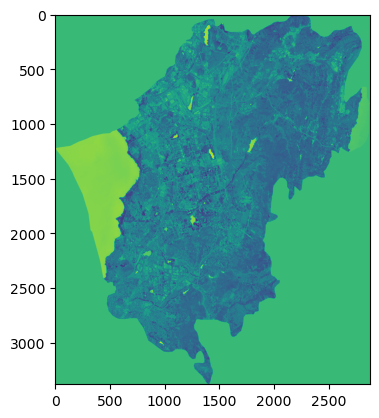

In [7]:
rsimg_arr = rsimg.read()
rsimg_arr = np.float32(rsimg_arr)
## 计算MNDWI指数
mndwi = (rsimg_arr[1] - rsimg_arr[3]) / (rsimg_arr[1] + rsimg_arr[3] + 0.00001)
plt.imshow(mndwi)

In [8]:
## 数据写出
path_out = "E://YNU//5//OpenSourceGIS//Act_6//OnClass//chenggong_utm48_mndwi.tif"
with rio.open(path_out, 'w', 
         driver=rsimg.driver, 
         width=rsimg.width, 
         height=rsimg.height,  
         count=1, 
         dtype=np.float32, 
         crs=rsimg.crs, 
         transform=rsimg.transform
         ) as dst: 
     dst.write(mndwi, 1)

### 矢量转栅格

In [9]:
path_vec = "E://YNU//5//OpenSourceGIS//Act_6//OnClass//chenggong_water.gpkg"
path_img = "E://YNU//5//OpenSourceGIS//Act_6//OnClass//chenggong_utm48.tif"

In [10]:
rsimg_rio = rio.open(path_img)
vec_gpd = gpd.read_file(path_vec)

In [11]:
vec_gpd.plot

In [12]:
from rasterio import features
vecToraster = features.rasterize(shapes = vec_gpd.geometry, 
                                 out_shape = rsimg_arr[0].shape, 
                                 default_value = 1, 
                                 fill = 0, 
                                 transform = rsimg_rio.transform, 
                                 dtype = None
                                 )

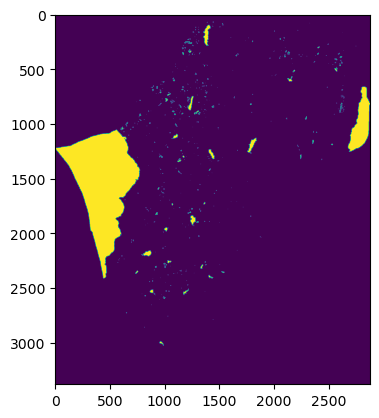

In [13]:
plt.imshow(vecToraster)

### 栅格转矢量

In [14]:
path_raster = "E:/YNU/5/OpenSourceGIS/Act_6/OnClass/chenggong_utm48_mndwi.tif"
raster_rio = rio.open(path_raster)
raster_arr = raster_rio.read(1)
raster_arr.shape
raster_rio.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 2875,
 'height': 3379,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 48N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32648"]]'),
 'transform': Affine(10.421454790528236, 0.0, 268167.02525260474,
        0.0, -9.543567381150961, 2765453.1872716597)}

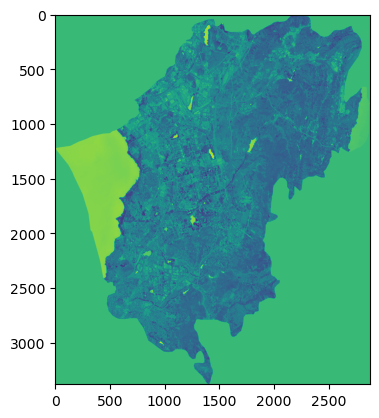

In [15]:
plt.imshow(raster_arr)

In [16]:
from shapely.geometry import shape
values, geos = [], []
for geo, value in features.shapes(np.float32(raster_arr), transform = raster_rio.transform):
    if value == 1:
        values.append(value)
        geos.append(geo)

geos = [shape(geo) for geo in geos]
dict = {'DN': values, 'geometry': geos}
region_gpd = gpd.GeoDataFrame(dict, crs = 'EPSG:32648')

C:\Users\Yihao Sun\AppData\Local\Temp\ipykernel_27888\1196418583.py:1: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  region_gpd.plot()


<Axes: >

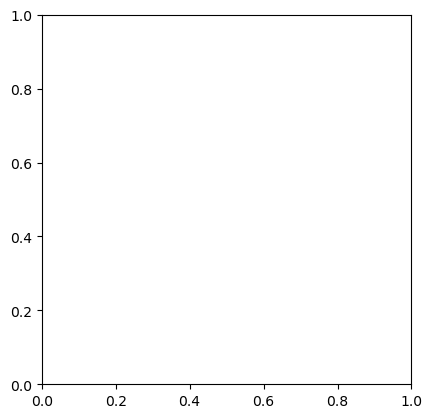

In [17]:
region_gpd.plot()